In [ ]:
### Install Qiskit and relevant packages, if needed
### IMPORTANT: Make sure you are on 3.10 > python < 3.12
%pip install -q qiskit[visualization]==1.0.2
%pip install -q qiskit-ibm-runtime
%pip install -q qiskit-aer
%pip install -q graphviz
%pip install -q qiskit-serverless -U
%pip install -q qiskit-transpiler-service -U
!pip install -q qiskit_algorithms
!pip install -q qiskit_machine_learning

In [209]:
# Import all in one cell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes,ZZFeatureMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties
from qiskit.visualization import plot_distribution
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import StatevectorEstimator
from qiskit_algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, POWELL
from qiskit.primitives import Sampler, Estimator
from qiskit_machine_learning.algorithms import VQC
from qiskit_aer import AerSimulator

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)

In [215]:
df = pd.read_csv('Credit card data sample3.csv')
# df = pd.read_csv('credit card .csv')
df.shape

(348, 31)

In [216]:
df = df.head(100)

In [212]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,171933,2.219537,-0.522871,-1.420302,-0.924451,-0.337605,-1.415039,-0.050859,-0.498773,-0.843595,...,0.065885,0.188144,0.196979,-0.057347,-0.039596,-0.310990,-0.039283,-0.060392,17.99,0
96,171933,-0.452822,1.650038,-2.385554,-0.602103,1.057404,-0.157200,0.021579,-2.398417,-1.068964,...,-1.049429,0.958276,0.089853,0.139759,-0.400229,0.509021,-0.112678,0.050756,42.81,0
97,171934,-0.181557,0.845111,0.217360,-0.586057,0.752814,-1.164822,1.230336,-0.383399,0.422314,...,-0.293692,-0.425263,-0.169772,-0.068895,0.261617,-0.097574,0.062056,-0.153896,30.00,0
98,171934,-0.347149,1.109492,-0.972439,-0.867137,1.479382,1.163589,0.275864,0.910857,-0.529666,...,-0.177324,-0.391248,0.180529,-0.820955,-0.601291,0.213928,0.149762,-0.002573,1.79,0


In [217]:
df = df.drop(columns=['Time'])
df = df.iloc[:, -6:]  # Selecting last 5 columns
df.head(10)

,V25,V26,V27,V28,Amount,Class
0,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,1.488901,0.566797,-0.010016,0.146793,1.00,1
5,1.488481,0.507963,0.735822,0.513574,1.00,1
6,1.605056,0.540675,0.737040,0.496699,1.00,1
7,0.128539,-0.189115,0.133558,-0.021053,149.62,0
8,0.167170,0.125895,-0.008983,0.014724,2.69,0
9,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [218]:
# Get the labels in array
labels = df['Class'].values
labels

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [219]:
# Get all the coefficient in array of array [[],[],[].....]
credit_card_PCA = df.drop(columns=['Class'])
coefficients=[]
for index, row in credit_card_PCA.iterrows():
    credit_coefficients = [complex(row[key]) for key in row.keys()]
    # print(bird_coefficients)
    # Add coefficients to the list of lists
    coefficients.append(credit_coefficients)
print(len(coefficients[0]))
print(coefficients)

5
[[(0.044519167+0j), (0.177839798+0j), (0.261145003+0j), (-0.143275875+0j), 0j], [(0.279798032+0j), (-0.145361715+0j), (-0.252773123+0j), (0.035764225+0j), (529+0j)], [(-0.156114265+0j), (-0.542627889+0j), (0.039565989+0j), (-0.153028797+0j), (239.93+0j)], [(0.252405262+0j), (-0.657487755+0j), (-0.827135715+0j), (0.84957338+0j), (59+0j)], [(1.488901448+0j), (0.566797273+0j), (-0.010016223+0j), (0.146792735+0j), (1+0j)], [(1.48848121+0j), (0.507962678+0j), (0.735821636+0j), (0.513573741+0j), (1+0j)], [(1.60505555+0j), (0.540675396+0j), (0.737040382+0j), (0.496699108+0j), (1+0j)], [(0.128539358+0j), (-0.189114844+0j), (0.133558377+0j), (-0.021053053+0j), (149.62+0j)], [(0.167170404+0j), (0.125894532+0j), (-0.008983099+0j), (0.014724169+0j), (2.69+0j)], [(-0.327641834+0j), (-0.139096572+0j), (-0.055352794+0j), (-0.059751841+0j), (378.66+0j)], [(0.647376035+0j), (-0.221928844+0j), (0.062722849+0j), (0.061457629+0j), (123.5+0j)], [(-0.206009588+0j), (0.502292224+0j), (0.21942223+0j), (0.21

In [220]:
print(coefficients)
print(labels)

[[(0.044519167+0j), (0.177839798+0j), (0.261145003+0j), (-0.143275875+0j), 0j], [(0.279798032+0j), (-0.145361715+0j), (-0.252773123+0j), (0.035764225+0j), (529+0j)], [(-0.156114265+0j), (-0.542627889+0j), (0.039565989+0j), (-0.153028797+0j), (239.93+0j)], [(0.252405262+0j), (-0.657487755+0j), (-0.827135715+0j), (0.84957338+0j), (59+0j)], [(1.488901448+0j), (0.566797273+0j), (-0.010016223+0j), (0.146792735+0j), (1+0j)], [(1.48848121+0j), (0.507962678+0j), (0.735821636+0j), (0.513573741+0j), (1+0j)], [(1.60505555+0j), (0.540675396+0j), (0.737040382+0j), (0.496699108+0j), (1+0j)], [(0.128539358+0j), (-0.189114844+0j), (0.133558377+0j), (-0.021053053+0j), (149.62+0j)], [(0.167170404+0j), (0.125894532+0j), (-0.008983099+0j), (0.014724169+0j), (2.69+0j)], [(-0.327641834+0j), (-0.139096572+0j), (-0.055352794+0j), (-0.059751841+0j), (378.66+0j)], [(0.647376035+0j), (-0.221928844+0j), (0.062722849+0j), (0.061457629+0j), (123.5+0j)], [(-0.206009588+0j), (0.502292224+0j), (0.21942223+0j), (0.2151

In [221]:
# Since we have total 29 fields coefficient so in amplitude encoding we can take the qubit num accordingly
import math
num_qubits = math.ceil(math.log2(len(coefficients[0])))
num_qubits =5

In [222]:
feature_map = ZZFeatureMap(feature_dimension=5)
feature_map

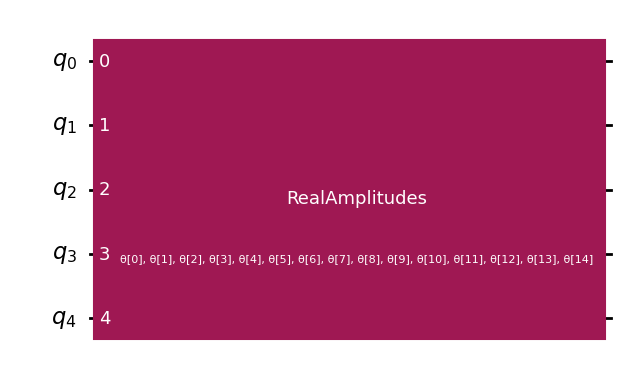

In [223]:
ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=2, insert_barriers=True)
qc = QuantumCircuit(num_qubits)  # create a circuit and append the RY variational form
qc.compose(ansatz, inplace=True)
qc.draw("mpl")

In [224]:
# from sklearn.model_selection import train_test_split
features = df.drop(columns=['Class'])  # Features (dropping 'label' column)
labels = df['Class']  # Target variable

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Display the shapes of the resulting datasets
# print("X_train shape:", X_train)
# print("X_test shape:", X_test)
# print("y_train shape:", y_train)
# print("y_test shape:", y_test)


from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)
print("X_train shape:", train_features.shape)
print("X_test shape:", test_features.shape)
print("y_train shape:", train_labels.shape)
print("y_test shape:", test_labels.shape)

X_train shape: (80, 5)
X_test shape: (20, 5)
y_train shape: (80,)
y_test shape: (20,)


In [225]:
from qiskit.primitives import Sampler, Estimator

sampler = Sampler()
estimator=Estimator()

In [226]:
backendSimulator = AerSimulator(method='statevector')

In [227]:
# Ensure train_labels is a 1D numpy array
if isinstance(train_labels, pd.Series):
    train_labels = train_labels.values
elif isinstance(train_labels, pd.DataFrame):
    train_labels = train_labels.squeeze().values  # Convert DataFrame to 1D array


In [228]:

# Define the observable
obs = SparsePauliOp("ZZZZZ")

# Define the estimator and pass manager
estimator = StatevectorEstimator() #To train we use StatevectorEstimator to get the exact simulation
pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=3, seed_transpiler=0)
# from qiskit import QuantumCircuit, transpile
# from qiskit.circuit.library import ZZFeatureMap

# Example: ZZFeatureMap as a feature map
feature_map = ZZFeatureMap(num_qubits, reps=2)

In [236]:
# Choose a real backend
from qiskit_ibm_runtime import SamplerV2 as Sampler, Session, Options, QiskitRuntimeService
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="16d6dd47657b972c1547b10fb7844fd1a407cc047430da104bd28a29a7394da2ea55115ecfcd09ba4e930ff8372156429ecf693000068b161a776b05b93c191b",
    set_as_default=True,
    overwrite=True,
)

# Load saved credentials
service = QiskitRuntimeService()
print(service.backends())
print("Available Backend", service.backends())
backend = service.least_busy()
print("least busy backend",backend.name)

print(
    f"Name: {backend.name}\n"
    f"Version: {backend.version}\n"
    f"No. of qubits: {backend.num_qubits}\n"
)
backend.status()
# backend = service.backend("ibm_osaka")

# Define a fake backend with the same properties as the real backend
# fake_backend = AerSimulator.from_backend(backend)

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibm_sherbrooke')>]
Available Backend [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibm_sherbrooke')>]
least busy backend ibm_kyoto
Name: ibm_kyoto
Version: 2
No. of qubits: 127



In [230]:
def cost_func(params, list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict):

    """Return cost function for optimization"""

    cost = 0
    for amplitudes, label in zip(list_coefficients, list_labels):
        qc = QuantumCircuit(num_qubits)
        # Amplitude embedding
        qc.append(feature_map, range(num_qubits))
        # Compose initial state + ansatz
        classifier = qc.compose(ansatz)
        # Transpile classifier
        transpiled_classifier = pm.run(classifier)
        # Transpile observable
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        # Run estimator
        pub = (transpiled_classifier, transpiled_obs, params)
        job = estimator.run([pub])
        # Get result
        result = job.result()[0].data.evs
        # Compute cost function (cumulative)
        cost += np.abs(result - label)

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(cost)

    # Print the iterations to screen on a single line
    print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], cost),
        end="\r",
        flush=True,
    )

    return cost


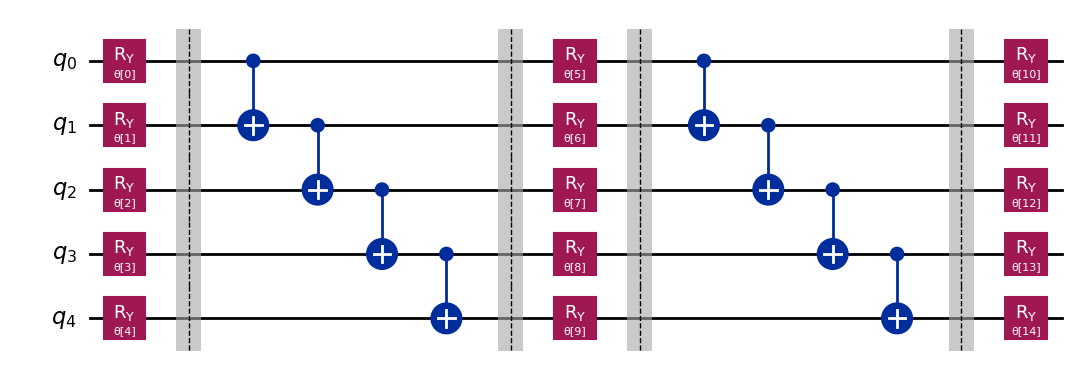

In [231]:
ansatz.decompose().draw('mpl')

In [47]:
cost_history_list = []
res_list = []
num_iterations=5
from qiskit.circuit import Parameter

def count_parameters(circuit):
    """Count the number of unique parameters in a QuantumCircuit."""
    parameters = set()
    for param in circuit.parameters:
        if isinstance(param, Parameter):
            parameters.add(str(param))
    return len(parameters)

# Initialize the session
with Session(service=service, backend=backend) as session:
    # estimator = Estimator(session=session)
    cost_history_list = []
    res_list = []
    num_iterations = 5

    num_parameters = count_parameters(ansatz)
    num_parameters = 20

    # Perform iterations
    for iteration in range(num_iterations):
        print(f"\nIteration {iteration + 1}:")

        # Generate initial parameters for this iteration
        params_0 = np.random.uniform(low=-np.pi, high=np.pi, size=num_parameters)

        # Ensure params_0 has exactly 20 elements
        assert len(params_0) == num_parameters, f"Expected {num_parameters} elements in params_0, got {len(params_0)}."

        # Initialize a callback dictionary
        callback_dict = {
            "prev_vector": None,
            "iters": 0,
            "cost_history": [],
        }

        # Minimize the cost function using scipy
        res = minimize(
            cost_func,
            params_0,
            args=(coefficients, labels, ansatz, obs, estimator, pm, callback_dict),
            method='cobyla',
            options={'maxiter': 10}
        )

        # Print the results after convergence
        print(res)

        # Save the results from different runs
        res_list.append(res)
        cost_history_list.append(callback_dict["cost_history"])

    # Display the results of all iterations
    for i, res in enumerate(res_list):
        print(f"\nResults of iteration {i + 1}:")
        print(res)
        print(f"Cost history: {cost_history_list[i]}")

    session.close()
# num_parameters = count_parameters(ansatz)
# num_parameters=20
# # Perform iterations
# for iteration in range(num_iterations):
#     print(f"\nIteration {iteration + 1}:")

#     # Generate initial parameters for this iteration
#     params_0 = np.random.uniform(low=-np.pi, high=np.pi, size=num_parameters)

#     # Ensure params_0 has exactly 15 elements
#     assert len(params_0) == num_parameters, f"Expected {num_parameters} elements in params_0, got {len(params_0)}."
#     # Initialize a callback dictionary
#     callback_dict = {
#         "prev_vector": None,
#         "iters": 0,
#         "cost_history": [],
#     }

#     # Minimize the cost function using scipy
#     res = minimize(
#         cost_func,
#         params_0,
#         args=(coefficients, labels, ansatz, obs, estimator, pm, callback_dict),
#         method='cobyla',
#         options={'maxiter': 10}
#     )

#     # Print the results after convergence
#     print(res)

#     # Save the results from different runs
#     res_list.append(res)
#     cost_history_list.append(callback_dict["cost_history"])

# # Display the results of all iterations
# for i, res in enumerate(res_list):
#     print(f"\nResults of iteration {i + 1}:")
#     print(res)
#     print(f"Cost history: {cost_history_list[i]}")


Iteration 1:
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 43.06110162441181
       x: [-1.018e+00 -2.055e+00 ...  2.075e+00  2.014e+00]
    nfev: 10
   maxcv: 0.0

Iteration 2:
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 43.41005544579921
       x: [ 2.021e+00  2.369e+00 ... -7.958e-01  1.735e+00]
    nfev: 10
   maxcv: 0.0

Iteration 3:
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 43.496355021471004
       x: [-5.693e-01  2.823e+00 ... -3.035e+00 -2.605e+00]
    nfev: 10
   maxcv: 0.0

Iteration 4:
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 43.90267984131074
       x: [ 2.928e-01 -5.586e-01 ...  1.051e+00  9.814e-01]
    nfev: 10
   maxcv: 0.0

Iteration 5:
 message: Maximum number of function evaluations has been exceeded.
 success: False
 

In [234]:
coefficients= coefficients[0:2]
labels=labels[0:2]

In [237]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_ibm_runtime import Session, Options, QiskitRuntimeService, EstimatorV2
from qiskit.transpiler import PassManager, preset_passmanagers
from qiskit.primitives import BackendEstimator
from scipy.optimize import minimize
import numpy as np
RR=''
def cost_func(params, list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict):
    """Return cost function for optimization"""
    cost = 0
    for amplitudes, label in zip(list_coefficients, list_labels):
        qc = QuantumCircuit(num_qubits)
        # Amplitude embedding
        qc.append(feature_map, range(num_qubits))
        # Compose initial state + ansatz
        classifier = qc.compose(ansatz)
        # Transpile classifier
        transpiled_classifier = pm.run(classifier)
        # Transpile observable
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        # Run estimator
        job = estimator.run([(transpiled_classifier, transpiled_obs, [params])])
        # estimator.run(circuits=[transpiled_classifier], observables=[transpiled_obs], parameter_values=[params])
        # result = job.result().values[0]
        result= job.result()[0].data.evs
        print(job.result)
        print(job.result())
        print(job.result()[0])
        print(job.result()[0].data)
        print(job.result()[0].data.evs)
        print("===")
        # print(result.optimal_paraneters.values())
        RR = job

        # Wait for job to complete
        # while job.status() not in [JobStatus.DONE, JobStatus.CANCELLED, JobStatus.ERROR]:
        #     continue

        # Get result
        # result = job.result().values[0]
        # Compute cost function (cumulative)
        cost += np.abs(result - label)
        print("cossst",cost)

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(cost)

    # Print the iterations to screen on a single line
    print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], cost),
        end="\r",
        flush=True,
    )
    print("callback_dict",callback_dict)
    print("cost",cost)
    return cost

def count_parameters(circuit):
    """Count the number of unique parameters in a QuantumCircuit."""
    parameters = set()
    for param in circuit.parameters:
        if isinstance(param, Parameter):
            parameters.add(str(param))
    return len(parameters)

# Define your quantum service and backend
# service = QiskitRuntimeService(channel="ibm_quantum", token="YOUR_TOKEN_HERE")
# backend = service.get_backend("ibm_kyiv")

# Prepare the pass manager
pm = preset_passmanagers.generate_preset_pass_manager(optimization_level=1, backend=backend)

# Define your options
options = Options()
options.execution.shots = 1024
options.execution.init_qubits = True

# Initialize your cost history list and result list
cost_history_list = []
res_list = []
num_iterations = 1

# Count the number of parameters in your ansatz
num_parameters = count_parameters(ansatz) + 5

# Initialize the session
with Session(service=service, backend=backend) as session:
    estimator = EstimatorV2(session=session)

    # Perform iterations
    for iteration in range(num_iterations):
        print(f"\nIteration {iteration + 1}:")

        # Generate initial parameters for this iteration
        params_0 = np.random.uniform(low=-np.pi, high=np.pi, size=num_parameters)

        # Ensure params_0 has exactly num_parameters elements
        assert len(params_0) == num_parameters, f"Expected {num_parameters} elements in params_0, got {len(params_0)}."

        # Initialize a callback dictionary
        callback_dict = {
            "prev_vector": None,
            "iters": 0,
            "cost_history": [],
        }

        # Minimize the cost function using scipy
        res = minimize(
            cost_func,
            params_0,
            args=(coefficients, labels, ansatz, obs, estimator, pm, callback_dict),
            method='cobyla',
            options={'maxiter': 1}
        )

        # Print the results after convergence
        print(res)

        # Save the results from different runs
        res_list.append(res)
        cost_history_list.append(callback_dict["cost_history"])

    # Display the results of all iterations
    for i, res in enumerate(res_list):
        print(f"\nResults of iteration {i + 1}:")
        print(res)
        print(f"Cost history: {cost_history_list[i]}")

    session.close()


<ipython-input-237-96356edbbd6b>:90: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = EstimatorV2(session=session)



Iteration 1:
<bound method RuntimeJobV2.result of <RuntimeJobV2('cstpfyqsgar0008byrrg', 'estimator')>>
PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(1,), dtype=float64>), stds=np.ndarray(<shape=(1,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(1,), dtype=float64>), shape=(1,)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})
PubResult(data=DataBin(evs=np.ndarray(<shape=(1,), dtype=float64>), stds=np.ndarray(<shape=(1,), dtype=float64>), ensemb

In [238]:
# Display the results of all iterations
for i, res in enumerate(res_list):
    print(f"\nResults of iteration {i + 1}:")
    print(res)
    print(f"Cost history: {cost_history_list[i]}")

    # Access and print the optimal parameters
    optimal_params = res.x
    print(f"Optimal parameters for iteration {i + 1}: {len(optimal_params)}")
# res_length = len(res_list)
# optimal_params= res_list[res_length-1].x
# print("optimal_params",optimal_params)


Results of iteration 1:
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 1.9959033907804398
       x: [ 2.354e+00  2.886e+00 ... -1.282e+00 -5.411e-01]
    nfev: 1
   maxcv: 0.0
Cost history: [array([1.99590339])]
Optimal parameters for iteration 1: 20


In [239]:
parameters = optimal_params[5:]
parameters

array([-1.41609565,  1.16253189,  2.91590285, -2.82626191, -1.8502375 ,
        2.17602456,  1.20434439,  0.66558703, -1.74672476,  1.41705756,
       -1.59696714, -1.62902771, -0.01713537, -1.28243051, -0.54106907])

In [240]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

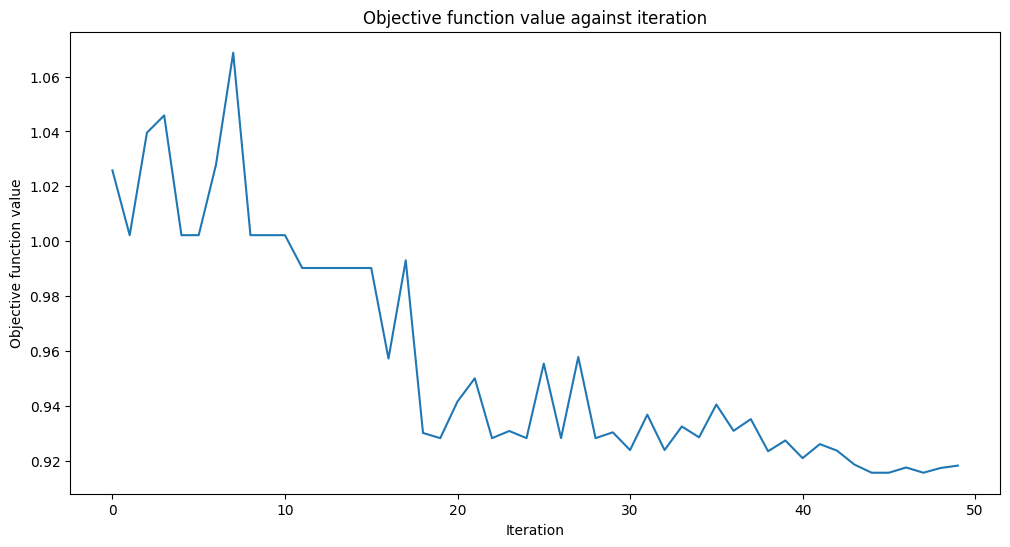

In [241]:

import time
from qiskit_machine_learning.algorithms.classifiers import VQC
optimizer = COBYLA(maxiter=50)
vqc = VQC(
    sampler=sampler,
    initial_point=optimal_params[5:],
  #  [ -0.93266144, -1.38222682, -1.53636453, -0.40734041, -1.46831766, 0.69203852,
  #   0.39505883, -2.74813689, 2.97627575, -0.80923609, 1.66314389, -0.42909159, -0.37534606, 2.82581914, 1.54308034],

# [
    # -1.83112985,  0.3842518 ,  2.05317414, -1.38829545, -2.07207094,
      #  -2.46959344, -0.79690994, -0.31004391,  1.09250039,  2.41571836,
      #   1.12234235, -1.97334503, -1.0971897 ,  2.5392068 ,  2.39732562,
      #   1.8363635 , -1.99341018, -3.00972829,  0.81296558, -1.45411104],
    # estimator=estimator,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# Estimator(session=session)
#     cost_func = lambda params: estimator.run([(isa_circuit, isa_observables, [params])]).result()[0].data.evs[0]
#     result = optimizer.minimize(cost_func, x0=init_point)    session.close()
# end_time = time.time()

# clear objective value history
objective_func_vals = []

# start = time.time()
vqc.fit(train_features, train_labels)
# elapsed = time.time() - start

# print(f"Training time: {round(elapsed)} seconds")

In [242]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.60
Quantum VQC on the test dataset:     0.50


In [99]:
len(optimal_params[5:])

15

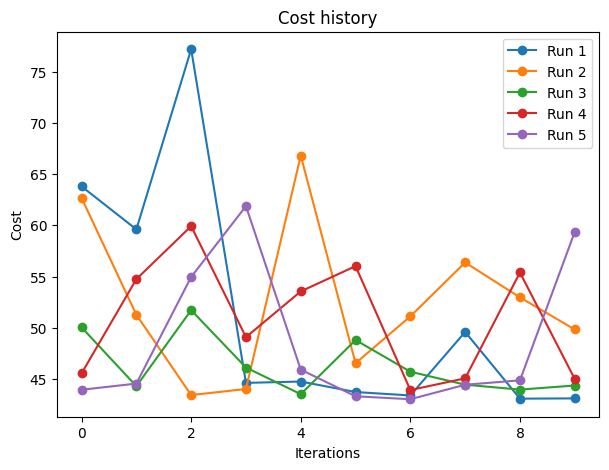

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost history')
ax.set_ylabel('Cost')
ax.set_xlabel('Iterations')

for i, cost_history in enumerate(cost_history_list):
    ax.plot(range(len(cost_history)), cost_history, marker='o', linestyle='-', label=f'Run {i+1}')

# Add a legend
ax.legend()

# Display the plot
plt.show()


In [ ]:
cost_history_list

[[178.7773762985321,
  176.4225298288458,
  189.47975263340993,
  177.68630267377648,
  177.77222989440403,
  176.94198203685133,
  177.35334193008532,
  175.63326116853494,
  176.96262606762335,
  176.20167279483329],
 [186.2357848996985,
  208.1724058989503,
  193.25995384162215,
  174.9176465127523,
  211.0916186910706,
  228.96553711159757,
  175.52651553967252,
  173.84460661907997,
  176.47382752838945,
  174.4898952772055],
 [184.6303741346062,
  203.05709000801428,
  176.18642801590443,
  266.47501743038976,
  177.71875259922263,
  176.06392839576196,
  175.85005350442864,
  176.55449886339977,
  174.07196374899127,
  175.16528317541494],
 [184.8999525648693,
  177.52994936262715,
  177.77199239634584,
  177.24929759574556,
  175.9474422806287,
  176.93257579414714,
  174.39226002110408,
  175.51616117194328,
  174.8228605940595,
  174.92041696547852],
 [175.73255480060743,
  215.32016133688967,
  182.43164278805557,
  190.93029991696596,
  240.72640108238662,
  206.19670813929

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibm_sherbrooke')>]


In [49]:
import numpy as np
from qiskit import QuantumCircuit
# Retrieve the initial parameters
num_params = 20

# Define the shape of the array (5D array with 'num_params' elements in each dimension)
shape = tuple([num_params] * 5)

# Generate random parameters
params_nd_array = np.random.uniform(low=-np.pi, high=np.pi, size=shape)

for it, params_0 in enumerate(params_nd_array):

    print('Iteration number: ', it)

    # Initialize a callback dictionary
    callback_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }
def test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm):
    """Return the performance of the classifier

    Parameters:
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        estimator (EstimatorV2): Statevector estimator
        pm (PassManager): Pass manager for transpilation

    Returns:
        list: List of test results
    """
    cost = 0
    for amplitudes,label in zip(list_coefficients, list_labels):
        qc = QuantumCircuit(num_qubits)
        # Amplitude embedding
        qc.append(feature_map, range(num_qubits))
        # Compose initial state + ansatz
        classifier = qc.compose(ansatz)
        # Transpile classifier
        transpiled_classifier = pm.run(classifier)
        # Transpile observable
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        # Run estimator
        pub = (transpiled_classifier, transpiled_obs, params_0)
        job = estimator.run([pub])
        # Get result
        result = job.result()[0].data.evs
        # Compute cost function (cumulative)
        cost += np.abs(result - label)

    return cost

# with Session(service=service, backend=backend) as session:
#      estimator = Estimator(session=session)
#      cost_func = lambda params: estimator.run([(isa_circuit, isa_observables, [params])]).result()[0].data.evs[0]
#      result = optimizer.minimize(cost_func, x0=init_point)
#      session.close()

def compute_performance(result_list, list_labels):
    """Return the performance of the classifier

    Parameters:
        result_list (list): List of results
        list_labels (list): List of labels

    Returns:
        float: Performance of the classifier
    """
    if isinstance(result_list, float):
        result_list = [result_list]  # Convert single result to list

    # Calculate the mean absolute error (MAE)
    absolute_errors = [np.abs(result - label) for result, label in zip(result_list, list_labels)]
    performance = np.mean(absolute_errors)

    return performance

Iteration number:  0
Iteration number:  1
Iteration number:  2
Iteration number:  3
Iteration number:  4
Iteration number:  5
Iteration number:  6
Iteration number:  7
Iteration number:  8
Iteration number:  9
Iteration number:  10
Iteration number:  11
Iteration number:  12
Iteration number:  13
Iteration number:  14
Iteration number:  15
Iteration number:  16
Iteration number:  17
Iteration number:  18
Iteration number:  19


KeyboardInterrupt: 

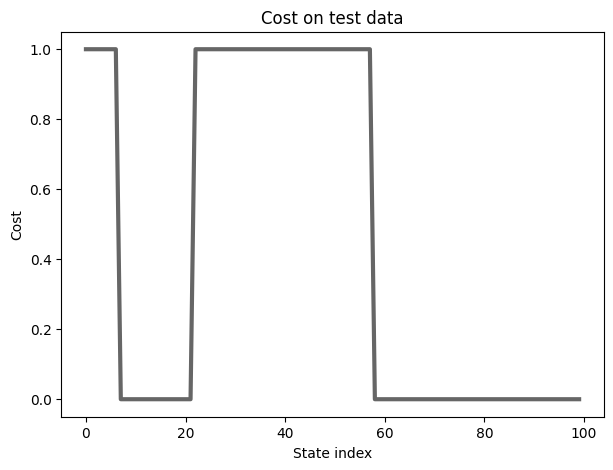

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

ax.plot(labels, 'k-', linewidth=3, alpha=0.6, label='Labels')

for index in range(len(res_list)):
    opt_params = res_list[index].x
    print(coefficients, labels, ansatz, obs, opt_params, estimator, pm)
    results_test = test_VQC(coefficients, labels, ansatz, obs, opt_params, estimator, pm)
    print(results_test)
    print(f"Performance for trial {index}: {compute_performance(results_test, labels)}")
    ax.plot(results_test, 'o--', label='Predictions trial '+str(index))

ax.legend()

In [194]:

import time
from qiskit_machine_learning.algorithms.classifiers import VQC
optimizer = COBYLA(maxiter=50)
vqc = VQC(
    sampler=sampler,
    initial_point=
    # optimal_params[5:],
 [ 0.65362848,  2.4520776 , -1.10915866,  1.7601695 , -2.42820737,
        1.77859775,  0.38398913,  0.52451907,  0.87348626,  1.32315532,
       -0.70526495, -2.26305384,  0.08918845, -0.429911  , -2.76315824],
# [
    # -1.83112985,  0.3842518 ,  2.05317414, -1.38829545, -2.07207094,
      #  -2.46959344, -0.79690994, -0.31004391,  1.09250039,  2.41571836,
      #   1.12234235, -1.97334503, -1.0971897 ,  2.5392068 ,  2.39732562,
      #   1.8363635 , -1.99341018, -3.00972829,  0.81296558, -1.45411104],
    # estimator=estimator,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# Estimator(session=session)
#     cost_func = lambda params: estimator.run([(isa_circuit, isa_observables, [params])]).result()[0].data.evs[0]
#     result = optimizer.minimize(cost_func, x0=init_point)    session.close()
# end_time = time.time()

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

KeyError: 0

In [102]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.60
Quantum VQC on the test dataset:     0.70


In [ ]:
Quantum VQC on the training dataset: 0.61
Quantum VQC on the test dataset:     0.65

In [ ]:
from qiskit.circuit import Parameter

def count_parameters(ansatz):
    """Count the number of unique parameters in a QuantumCircuit."""
    parameters = set()
    for param in ansatz.parameters:
        if isinstance(param, Parameter):
            parameters.add(str(param))
    return len(parameters)

# Example usage:

# ansatz = EfficientSU2(num_qubits=3, reps=2)  # Example ansatz circuit
num_parameters = count_parameters(ansatz)
# shape = tuple([num_parameters] * 5)

# Generate random parameters
shape = (15, 15, 15, 15, 15)

# Generate random parameters
params_5d_array = [np.random.uniform(low=-np.pi, high=np.pi, size=num_parameters).tolist() for _ in range(5)]

print(f"Number of parameters in ansatz: {num_parameters}")
# params_0_list = np.random.uniform(low=-np.pi, high=np.pi, size=3)
print(params_5d_array)
# Intialize the lists to store the results from different runs
cost_history_list = []
res_list = []

# # Retrieve the initial parameters
# params_0_list = np.load("params_0_list.npy")

# params_0_list = np.random.uniform(low=-np.pi, high=np.pi, size=)

for it, params_0 in enumerate(params_5d_array):

    print('Iteration number: ', it)
    # print(params_0)
    # Initialize a callback dictionary
    callback_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }

    # Minimize the cost function using scipy
    res = minimize(
        cost_func,
        params_0,
        args=(coefficients, labels, ansatz, obs, estimator, pm, callback_dict),
        method="cobyla", # Classical optimizer
        options={'maxiter': 200}) # Maximum number of iterations

    # Print the results after convergence
    print(res)

    # Save the results from different runs
    res_list.append(res)
    cost_history_list.append(callback_dict["cost_history"])


Number of parameters in ansatz: 15
[[-3.014063980710116, 1.4933670189043031, 0.9926299429658005, 1.6661543906604726, -1.7793868233559378, 2.403533121207694, 2.1825066008663967, 3.135067636908974, -0.3079825832936378, 2.961351178238563, 3.1055772433670104, -1.4505156284629115, -2.8178138324212916, -1.1039448577419186, -2.8576493173219677], [-2.9552568115463806, 0.6319671431761331, -2.164876089734341, -2.9981697104124443, -0.7621831343397916, -2.452914654315363, 2.8573826318544793, -2.010434622614879, 0.1254240974925449, 2.1002640439726363, 1.4267181188385356, -1.037023835842834, 2.7666225114537584, 0.3136909429545729, 2.426615203268083], [-1.3149600412433762, -1.5475519081449225, 2.41533477213531, 1.6952068123011292, -1.7973266227453937, 2.9596902887989867, 0.19759229983819981, -0.1411679843054956, -0.09047759070651251, 0.05550486775504915, -0.044453852160131646, -0.2992512095090989, -1.5872460647108344, 2.916776639613137, -0.6917649390721521], [2.7530431561870694, -0.48816657281907894,

ValueError: Length of ('x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'θ[0]', 'θ[1]', 'θ[2]', 'θ[3]', 'θ[4]', 'θ[5]', 'θ[6]', 'θ[7]', 'θ[8]', 'θ[9]', 'θ[10]', 'θ[11]', 'θ[12]', 'θ[13]', 'θ[14]') inconsistent with last dimension of [-3.01406398  1.49336702  0.99262994  1.66615439 -1.77938682  2.40353312
  2.1825066   3.13506764 -0.30798258  2.96135118  3.10557724 -1.45051563
 -2.81781383 -1.10394486 -2.85764932]

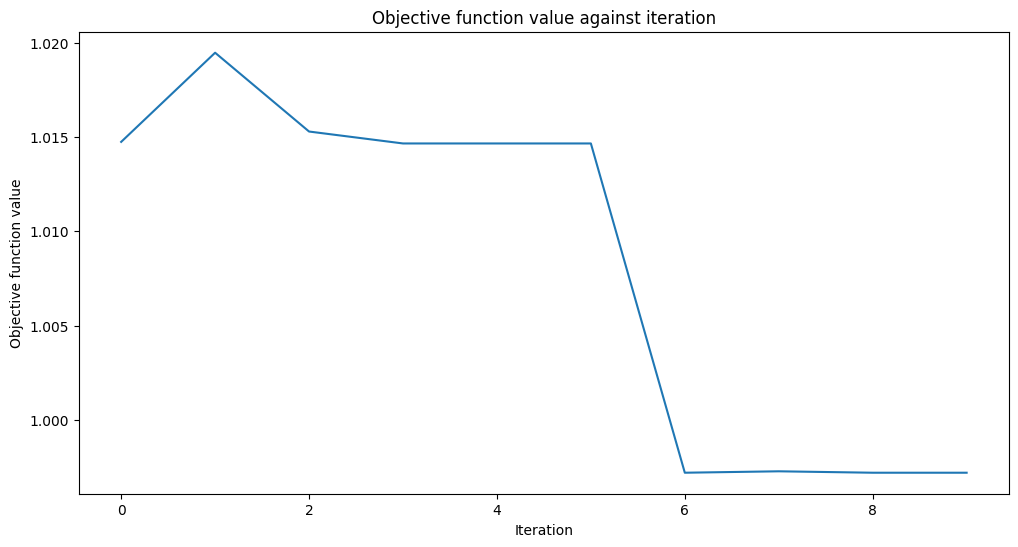

Training time: 41 seconds


In [ ]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
optimizer = COBYLA(maxiter=10)
vqc = VQC(
    sampler=sampler,
    # estimator=estimator,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# Estimator(session=session)
#     cost_func = lambda params: estimator.run([(isa_circuit, isa_observables, [params])]).result()[0].data.evs[0]
#     result = optimizer.minimize(cost_func, x0=init_point)    session.close()
# end_time = time.time()

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.58
Quantum VQC on the test dataset:     0.56


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming 'features' and 'labels' are your data arrays or DataFrames
# Split the data into training and testing sets
# train_features, test_features, train_labels, test_labels = train_test_split(
#     features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
# )

# Initialize the classifier (Logistic Regression in this example)
classifier = LogisticRegression()

# Train the classifier on the training data
classifier.fit(train_features, train_labels)

# Predict on both training and testing data
train_predictions = classifier.predict(train_features)
test_predictions = classifier.predict(test_features)

# Calculate accuracy for both training and testing sets
train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

# You can add more evaluation metrics as needed


Training Accuracy: 0.7625
Testing Accuracy: 0.55


In [ ]:
# # from qiskit_machine_learning.datasets import ad_hoc_data

# # Considering Two class problem Orange vs Blue ball and 2D input feature dataset
# feature_dim = 2

# # Splliting data to Train and Test - Train size 20, Test size 10
# train_data, train_labels, test_data, test_labels = ad_hoc_data(
#     training_size=20,
#     test_size=10,
#     n=feature_dim,
#     gap=0.3,
#     plot_data=True
# )

In [ ]:
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_algorithms.optimizers import COBYLA
import qiskit_machine_learning as qkml

# Define your optimizer (e.g., COBYLA with maxiter=10)
optimizer = COBYLA(maxiter=10)

# Initialize VQC with required parameters
vqc = VQC(
    optimizer=optimizer,
    feature_map=feature_map,
    ansatz=ansatz,
    callback=callback_graph  # Optional callback function
)

# Save the Qiskit Runtime program
program_id = qkml.runtime.save(vqc)
print(f"Program ID: {program_id}")


AttributeError: module 'qiskit_machine_learning' has no attribute 'runtime'

### Implement Apmplitude Embedding for encoding quantum state

In [ ]:

# # Checking different row by changing the index
# index_credit = 2  # checking 2nd row coefficient
# amplitudes = coefficients[index_credit]

# # Build the amplitude embedding
# qc = QuantumCircuit(num_qubits)
# qc.initialize(amplitudes, range(num_qubits))
# # qc.measure_all()

# # # Draw the amplitude embedding circuit
# # qc.draw(output="mpl")